In [1]:
import pandas as pd
import geopandas

''' The sidewalk ratio dataset does not have neighborhood names instead containing 
geoid10 as the location information, so I'm using the 2010 Pittsburgh census data 
set which has both geoid10 and neighborhood information to map between the two. 
''' 
census = pd.read_csv("2010_Census_Block_Groups.csv").filter(['hood','geoid10'])
census.head()

,hood,geoid10
0,Central Oakland,420030405001
1,North Oakland,420030404001
2,West Oakland,420030402002
3,Crawford-Roberts,420030305002
4,Crawford-Roberts,420030305001


In [2]:
# Create a dictionary which maps each geoid10 to the neighborhood it is in
geo_to_hood = {}
for index, row in census.iterrows():
    if row['geoid10'] not in geo_to_hood:
          geo_to_hood[row['geoid10']] = row['hood']

# Demonstration
print(geo_to_hood[420030405001])

Central Oakland


In [3]:
sr = pd.read_csv("sidewalk_ratio.csv")
# print(geo_to_hood[sr['GEOID'][35]])
 
sr_ratios = {}
ratio_count = 0
for (index, row) in sr.iterrows():
    try:
        if geo_to_hood[row['GEOID']] in sr_ratios:
            ratio_list = sr_ratios[geo_to_hood[row['GEOID']]]
            #ratio_list[0] += 1
            ratio_list.append(row['Ratio'])
            sr_ratios[geo_to_hood[row['GEOID']]] = ratio_list
        else:
            ratio_list = []
            ratio_list.append(row['Ratio'])
            sr_ratios[geo_to_hood[row['GEOID']]] = ratio_list
    except:
        continue

# Demonstration
print(sr_ratios["Central Oakland"])

[1.6020824519999999, 1.489100874, 1.41298434]


In [5]:
# Get the average sidewalk ratio for each neighborhood
for key, value in sr_ratios.items():
   avg = 0
   for item in value:
        avg += item
   avg /= len(value)
   sr_ratios[key] = avg
       
print("Central Oakland's sidewalk ratio is " + str(sr_ratios["Central Oakland"]))    

Central Oakland's sidewalk ratio is 1.501389222


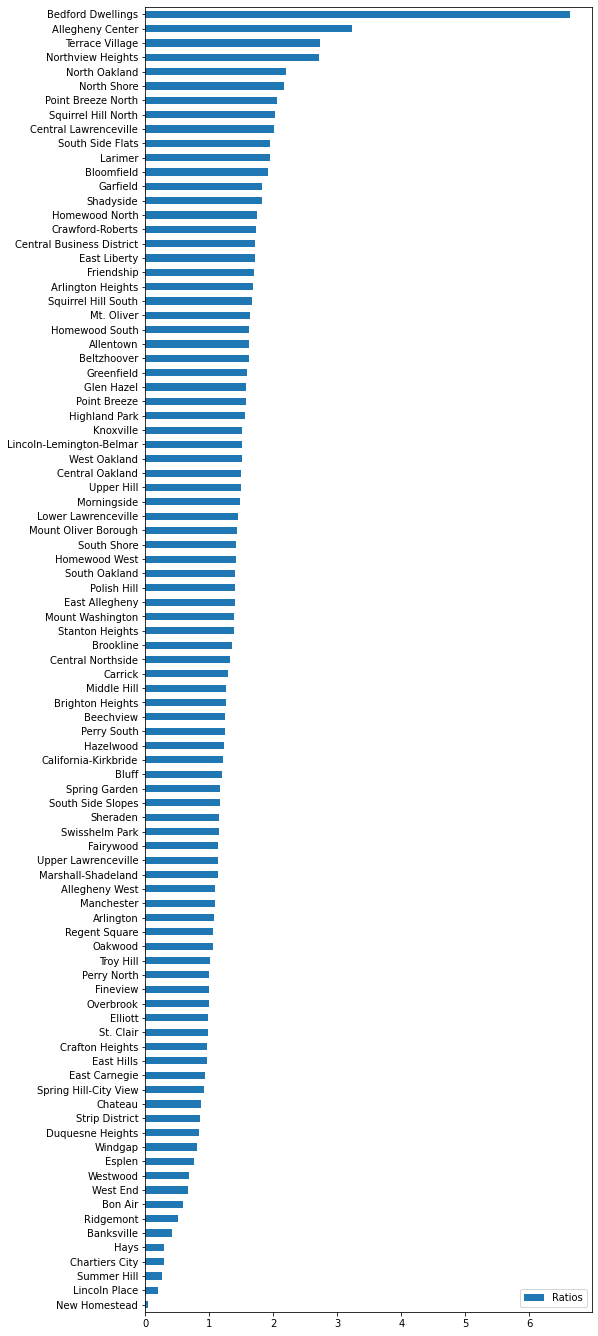

In [36]:
ratios_df = pd.DataFrame.from_dict(sr_ratios, orient="index", columns=['Ratios'])
ratios_df = ratios_df.sort_values(by="Ratios", ascending=True)
ratios_df.plot(kind="barh", figsize=(8, 24))
# print(ratios_df.info())